In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer,OrdinalEncoder
from xverse.transformer import WOE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, plot_confusion_matrix

from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import warnings 
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize']=[15,8]

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score

In [3]:
xtrain = pd.read_csv("xtrain_final.csv")
xtest = pd.read_csv("xtest_final.csv")
ytrain = pd.read_csv("ytrain_final.csv")
ytest = pd.read_csv("ytest_final.csv")



((52270, 37), (13068, 37))

In [4]:
pd.options.display.max_columns = None

xtrain.head()



,Gender,Contacted,Primary_Bank_Type,City_Category_B,City_Category_C,Employer_Category1_B,Employer_Category1_C,Source_Category_B,Source_Category_C,Source_Category_D,Source_Category_E,Source_Category_F,Source_Category_G,Age_Cat_Middle-Aged,Age_Cat_Old,Age_Cat_Young,Employer_Cat3_MSF,Employer_Cat3_MSME,Employer_Cat3_PVT,Employer_Cat3_VSF,Employer_Category2,Var1,Lead_Creation_Month,City_Code,Source,Monthly_Income,Existing_EMI,Loan_Amount,Loan_Period,Interest_Rate,loan_period_months,emi_recal,EMI-Monthly_Income_Ratio,Income_loan_Ratio,IR_15-20,IR_20-25,IR_25+
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,4,0,7,0.148588,0.059791,1680.0,0.0,19600,3.4,18.040,40.8,646,0.384524,0.879263,1,0,0
1,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,4,2,5,-0.267721,0.059791,1350.0,0.0,30000,5.0,20.000,60.0,795,0.588889,1.597424,1,0,0
2,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,10,7,0.148588,0.059791,5200.0,0.0,90000,4.4,15.108,52.8,2344,0.450769,1.266409,1,0,0
3,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,4,0,12,-0.267721,-0.279869,1500.0,0.0,22000,4.0,35.500,48.0,864,0.576000,1.085929,0,0,1
4,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,4,2,7,0.034822,0.059791,1500.0,600.0,11000,5.0,20.000,60.0,291,0.594000,0.527150,1,0,0


In [15]:
xtrain.shape,xtest.shape

((52270, 39), (13068, 39))

In [26]:
tuning_params={'criterion':['gini','entropy'],'class_weight':['balanced'],'max_depth':list(np.arange(4,20,2)),
    'min_samples_split':list(np.arange(50,1500,50)),
    'max_features':list(np.arange(5,40,2))}



In [27]:
GRID_MOD=GridSearchCV(estimator=DecisionTreeClassifier(),param_grid=tuning_params,scoring='roc_auc',cv=5)


In [28]:
GRID_MOD.fit(xtrain,ytrain)



GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': [5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                          25, 27, 29, 31, 33, 35, 37, 39],
                         'min_samples_split': [50, 100, 150, 200, 250, 300, 350,
                                               400, 450, 500, 550, 600, 650,
                                               700, 750, 800, 850, 900, 950,
                                               1000, 1050, 1100, 1150, 1200,
                                               1250, 1300, 1350, 1400, 1450]},
             scoring='roc_auc')

In [31]:
GRID_MOD.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 15,
 'min_samples_split': 1250}

In [32]:
dtree=DecisionTreeClassifier(class_weight=GRID_MOD.best_params_.get('class_weight'),criterion=GRID_MOD.best_params_.get('criterion'),max_depth=GRID_MOD.best_params_.get('max_depth'),max_features=GRID_MOD.best_params_.get('max_features'),min_samples_split=GRID_MOD.best_params_.get('min_samples_split'))

In [33]:
dtree.fit(xtrain, ytrain)
dtree.score(xtrain, ytrain), dtree.score(xtest, ytest)

(0.6775779605892481, 0.6818947046219773)

In [37]:
ypred_train_dt = dtree.predict(xtrain)
print(confusion_matrix(ytrain, ypred_train_dt))
print(classification_report(ytrain, ypred_train_dt))

ypred_test_dt = dtree.predict(xtest)
print(confusion_matrix(ytest, ypred_test_dt))
print(classification_report(ytest, ypred_test_dt))

[[34714 16742]
 [  111   703]]
              precision    recall  f1-score   support

           0       1.00      0.67      0.80     51456
           1       0.04      0.86      0.08       814

    accuracy                           0.68     52270
   macro avg       0.52      0.77      0.44     52270
weighted avg       0.98      0.68      0.79     52270

[[8756 4111]
 [  46  155]]
              precision    recall  f1-score   support

           0       0.99      0.68      0.81     12867
           1       0.04      0.77      0.07       201

    accuracy                           0.68     13068
   macro avg       0.52      0.73      0.44     13068
weighted avg       0.98      0.68      0.80     13068



In [41]:
%matplotlib inline

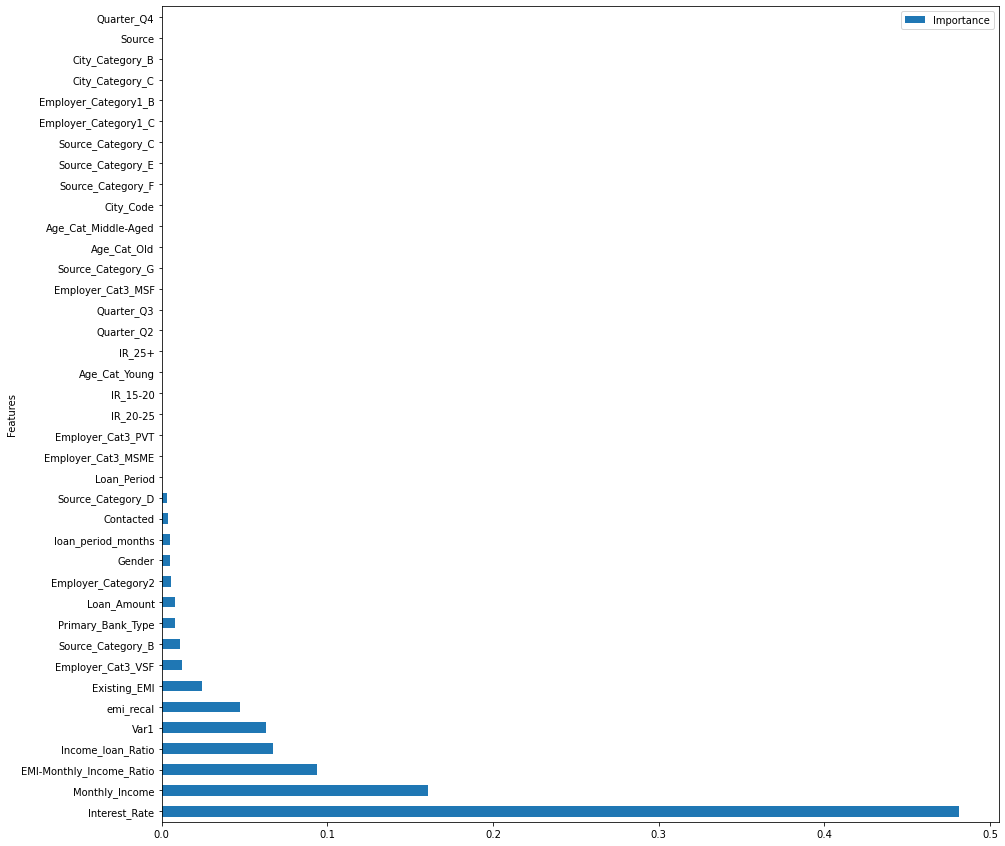

In [42]:
plt.rcParams['figure.figsize']=[15,15]
pd.DataFrame({'Features':xtrain.columns,'Importance':dtree.feature_importances_}).sort_values(by='Importance',ascending=False).set_index('Features').plot(kind='barh')
plt.show()

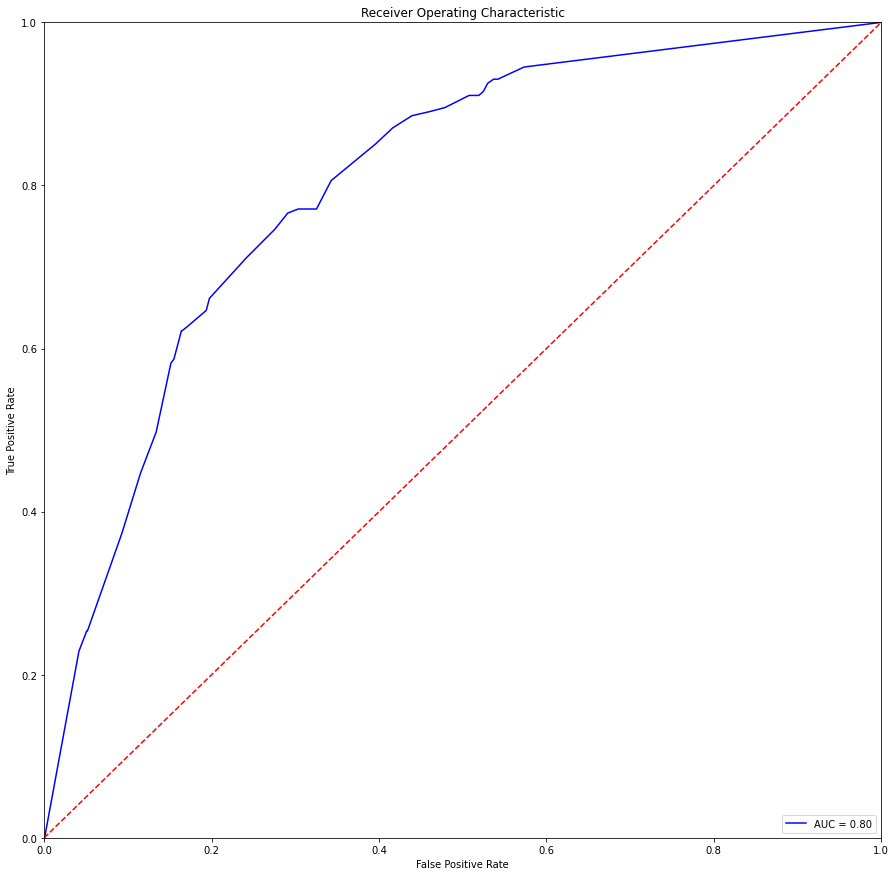

In [43]:
import sklearn.metrics as metrics
probs = dtree.predict_proba(xtest)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(ytest, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()